# CNN on MNIST

In this notebook, we train one of oldest CNNs, called [_LeNet_](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), to classify hand-written digits from 0 to 9. The dataset is public and called [_MNIST_](http://yann.lecun.com/exdb/mnist/). MNIST is widely used for an introductory machine learning (ML) courses/lectures, and not limited to CNN. LeNet is one of the very first CNN application and nearly 2 decades old, and first applied on MNIST.

First we go over MNIST data set, LeNet construction, and finally training.

In [1]:
from __future__ import print_function
import torch
import numpy as np

## MNIST data set
Most, if not all, ML libraries provide an easy way (API) to access MNIST dataset. This is true in `pytorch` as well. MNIST dataset in `Dataset` instance is available from `torchvision`. 

In [2]:
from torchvision import datasets, transforms

LOCAL_DATA_DIR = './data' # this is where data files are downloaded

dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
print(len(dataset),'images prepared!')

60000 images prepared!


Let's visualize data with a label.

Label: 5


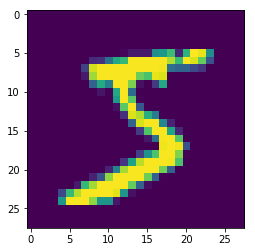

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# Print label
print('Label:',dataset[0][1])
# Draw data
plt.imshow(dataset[0][0].view([28,28]))
plt.show()

Next, let's crate `DataLoader` for training. If you have not learned what `DataLoader` is, [read this notebook](https://github.com/watchmal/ExampleNotebooks/blob/master/HKML%20DataLoader.ipynb).

In [4]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=20,shuffle=True,num_workers=1,pin_memory=True)

## Defining a network
In `pytorch`, a network is defined as a `torch.Module` inherited class. All `torch.Module` have two functions: _forward_ and _backward_. The forward function runs data through the CNN and makes a prediction. The backward propagates gradient, computed based on the error from the forward function call, to train the network. 

LeNet has 2 convolution layers, each followed by rectified linear unit (ReLU) and max-pooling, for feature extractions. Then the extracted features run through two hidden layers multi-layer perceptron (MLP) at the end for classifying the input image data into digits (0 to 9).

In [5]:
class LeNet(torch.nn.Module):
    def __init__(self):
        
        super(LeNet, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,6,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(6,16,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2) )
        # classifier MLP
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,120),
            torch.nn.ReLU(),
            torch.nn.Linear(120,84),
            torch.nn.ReLU(),
            torch.nn.Linear(84,10) )

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [6]:
class BLOB:
    pass
blob=BLOB()
blob.net       = LeNet().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [7]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = blob.data.cuda()
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = blob.label.cuda() #label = torch.stack([ torch.as_tensor(l) for l in np.hstack(label) ])
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss,#.cpu().detatch(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


Now we are ready for training! Let's write a loop to load data, call forward, and call backward.

In [8]:
# Set the network to training mode
blob.net.train()

# Let's train 2000 steps
stop_iteration = 2000
# Loop over data samples and into the network forward function
for i,data in enumerate(train_loader):
    # data and label
    blob.data, blob.label = data
    # call forward
    res = forward(blob,True)
    # once in a while, report
    if (i+1)%100 == 0:
        print('Iteration',i,'... Loss',res['loss'],'... Accuracy',res['accuracy'])
    if (i+1)==stop_iteration:
        break
    backward(blob)
    

Iteration 99 ... Loss tensor(0.5482, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.85
Iteration 199 ... Loss tensor(0.1940, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.95
Iteration 299 ... Loss tensor(0.1373, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 1.0
Iteration 399 ... Loss tensor(0.6558, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.8
Iteration 499 ... Loss tensor(0.3005, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.9
Iteration 599 ... Loss tensor(0.1749, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.9
Iteration 699 ... Loss tensor(0.1262, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.95
Iteration 799 ... Loss tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 1.0
Iteration 899 ... Loss tensor(0.0474, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 1.0
Iteration 999 ... Loss tensor(0.1220, device='cuda:0', grad_fn=<NllLossBackward>) ... Accuracy 0.95
Iterati

## Evaluation
It seems that the network was trained well on the data set. Let's evaluate its performance on a separate data sample.

In [9]:
# load the test dataset
dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
# create DataLoader
test_loader = torch.utils.data.DataLoader(dataset,batch_size=20,shuffle=False,num_workers=1,pin_memory=True)
# set the network to test (non-train) mode
blob.net.eval()
# loop over test set, run forward for analysis
accuracy_array = []
for i,data in enumerate(test_loader):
    blob.data, blob.label = data
    res = forward(blob,True)
    accuracy_array.append(res['accuracy'])

# report accuracy
accuracy_array = np.hstack(accuracy_array)
mean = accuracy_array.mean()
std  = accuracy_array.std()
print('Accuracy mean:',mean,'... std:',std)

Accuracy mean: 0.9708 ... std: 0.04286443747443795
